# In this notebook, the pooling procedure that is used in the thesis is evaluated

PXD003406 and PXD003407 are especially interesting as they both contain fractioned and whole lysate samples of the same cells, albeit with or wtihout treatment

PCA plots are made to show the effect of pooling on similarity

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

In [3]:
import mysql.connector

conn = mysql.connector.connect(user='root', password='password', host='127.0.0.1', port='3306',database='expression_atlas_cells')
mycursor = conn.cursor(buffered = True)

# check the connection
if conn.is_connected():
    print("connection succesfull")
else:
    print("no connection")

connection succesfull


In [350]:
# Load all the data that is imported and used

assay_project_query = "SELECT * FROM assay"
assay_project_data = pd.read_sql_query(assay_project_query, conn)

project_query = "SELECT project_id, PXD_accession FROM project"
project_data = pd.read_sql_query(project_query, conn)

assay_cell_query = "SELECT assay_id, cell_id FROM cell_to_assay"
assay_cell_data = pd.read_sql_query(assay_cell_query, conn)

cell_query = "SELECT * FROM cell"
cell_data = pd.read_sql_query(cell_query, conn)

full_df = pd.merge(assay_project_data, assay_cell_data, on = "assay_id")
full_df = pd.merge(full_df, cell_data, on = "cell_id")
full_df = pd.merge(full_df, project_data, on = "project_id")
print(full_df.shape)
full_df.head()

(3152, 11)


,assay_id,project_id,filename,cell_id,cell_line,disease,treatment,tissue_type,sub_cell,organ_id,PXD_accession
0,30960,1815,3B10-1,545,Hep3B,hepatocellular carcinoma,/,liver,/,None,PXD000533
1,30961,1815,3B10-2,545,Hep3B,hepatocellular carcinoma,/,liver,/,None,PXD000533
2,30962,1815,3B1-1,545,Hep3B,hepatocellular carcinoma,/,liver,/,None,PXD000533
3,30963,1815,3B11-1,545,Hep3B,hepatocellular carcinoma,/,liver,/,None,PXD000533
4,30964,1815,3B11-2,545,Hep3B,hepatocellular carcinoma,/,liver,/,None,PXD000533


In [351]:
# add annotation of pooling; This is saved in the pooling.log file. The format is INFO:root:filename: poolID
pooling_annotation = {"filename":[], "poolID":[]}

with open("pooling.log", "r") as logfile:
    for line in logfile:
        filename = line.split(":")[-2]
        poolID = line.split(":")[-1]

        pooling_annotation["filename"].append(filename)
        pooling_annotation["poolID"].append(poolID.strip())

pooling_annotation = pd.DataFrame(pooling_annotation)

full_df = pd.merge(full_df, pooling_annotation, on="filename")
full_df["Type"] = full_df.poolID.apply(lambda x: "Whole_lysate" if x=="0" else "Fraction")

In [352]:
full_df[full_df.PXD_accession == "PXD005946"]

,assay_id,project_id,filename,cell_id,cell_line,disease,treatment,tissue_type,sub_cell,organ_id,PXD_accession,poolID,Type


In [353]:
# 0 --> whole lysate
# Other integer --> poolid to combine in a pxd project
# anything else: drop

HUVEC_subset = full_df[full_df.cell_line=="HUVEC"]
HUVEC_subset.groupby("PXD_accession").poolID.value_counts()

PXD_accession  poolID
PXD003406      0         10
               1          4
               2          4
               3          4
               4          4
PXD003407      0         10
               1          4
               2          4
               3          4
               4          4
Name: poolID, dtype: int64

In [354]:
def get_pxd_data(list_PXD, NSAF, meta):
    """
    list_PXD: list of project identifiers for which to return the NSAF data
    NSAF: the protein expression matrix with associated assay_ids
    meta: the associated metadata

    Returns [expression matrix of the list_PXD, associated metadata with matching indices]
    """
    full_table = pd.merge(NSAF, meta, on = "assay_id")
    full_table = full_table[full_table.PXD_accession.isin(list_PXD)]
    full_table.dropna(how='all', axis = 1, inplace = True)

    NSAF, meta = full_table.iloc[:,:-11].set_index("assay_id").copy(), full_table.iloc[:,-11:].reset_index(drop = True).copy()

    return NSAF, meta


# HUVEC

In [355]:
nonPooledNSAF = pd.read_csv('proteome_nsaf_2.csv')
nonPooledNSAF = pd.pivot_table(nonPooledNSAF, values = "NSAF", index = "assay_id", columns = 'uniprot_id').reset_index()

pooledNSAF = pd.read_csv('pooled_proteome_nsaf_1.csv')
pooledNSAF = pd.pivot_table(pooledNSAF, values = "NSAF", index = "assay_id", columns = 'uniprot_id').reset_index()

In [356]:
HUVEC_pooled, metaPooled = get_pxd_data(["PXD003406","PXD003407"], pooledNSAF, full_df)
HUVEC_nonPooled, metaNonPooled = get_pxd_data(["PXD003406","PXD003407"], nonPooledNSAF, full_df)
metaPooled.loc[:,["Type"]] = metaPooled.Type.apply(lambda x: "Pooled" if x == "Fraction" else x)

In [357]:
non_common_columns = list(set(HUVEC_nonPooled.columns) - set(HUVEC_pooled.columns))
print(f"Disjunction of proteins: {len(non_common_columns)}")
print(f"Disjunction proteins in nonPooledNSAF: {len(set(HUVEC_nonPooled) & set(non_common_columns))}")

Disjunction of proteins: 125
Disjunction proteins in nonPooledNSAF: 125


In [358]:
HUVEC_nonPooled = HUVEC_nonPooled.loc[:, ~HUVEC_nonPooled.columns.isin(non_common_columns)]

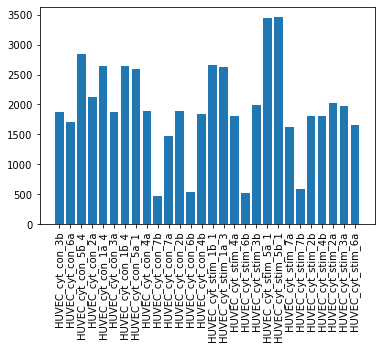

In [359]:
plt.xticks(rotation = 90)
_ = plt.bar(x=metaPooled["filename"], height=HUVEC_pooled.notna().sum(axis=1))
plt.show()

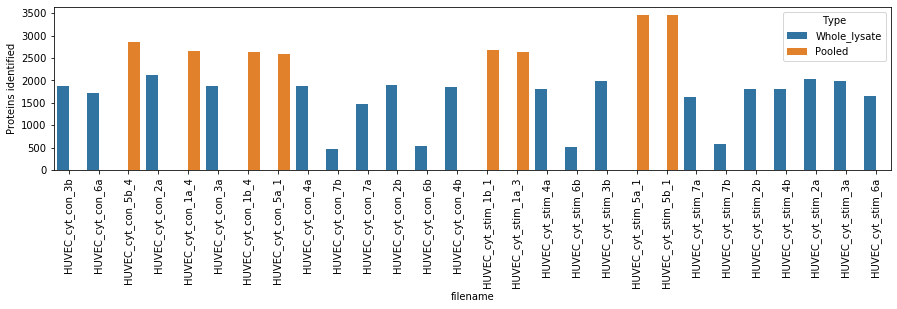

In [360]:
plt.figure(figsize=(15,3))
plt.xticks(rotation = 90)
plt.ylabel("Proteins identified")
sns.barplot(x=metaPooled["filename"], y=HUVEC_pooled.notna().sum(axis=1).tolist(), hue = metaPooled["Type"])

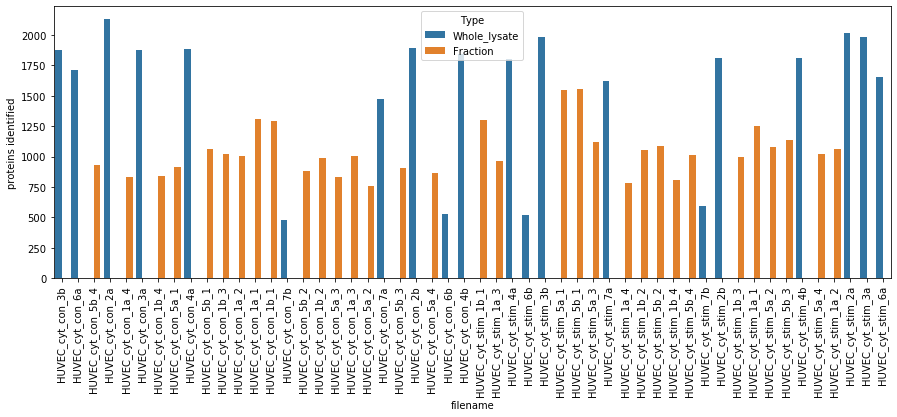

In [361]:
plt.figure(figsize=(15,5))
plt.xticks(rotation = 90)
plt.ylabel("proteins identified")
sns.barplot(x=metaNonPooled["filename"], y=HUVEC_nonPooled.notna().sum(axis=1).tolist(), hue = metaNonPooled["Type"])

Let's now see the similarity between the datapoints by plotting them in a 2 dimensional plot. Here, dimensionality reduction techniques are required.

In [311]:
def plotDataNP(results, scaling = 'auto'):
    fig, ax = plt.subplots(1,2, figsize = (20,7))
    fig.suptitle('No pooling')

    if scaling != "auto":
        for axi in ax.reshape(-1):
            axi.set_xlim([-scaling[0],scaling[0]])
            axi.set_ylim([-scaling[1],scaling[1]])
            
    ax[0].set_title("Minmax normalization")
    ax[1].set_title("no scaling")

    sns.scatterplot(data=pd.DataFrame(results[0], columns = ["UMAP1", "UMAP2"]), x= "UMAP1", y = "UMAP2", hue = metaNonPooled["poolID"], style=metaNonPooled['treatment'], ax=ax[0])
    sns.scatterplot(data=pd.DataFrame(results[1], columns = ["UMAP1", "UMAP2"]), x= "UMAP1", y = "UMAP2", hue = metaNonPooled["poolID"], style=metaNonPooled['treatment'], ax=ax[1])

In [312]:
def plotDataP(results, scaling = "auto"):
    """scaling: [x, y]"""

    fig, ax = plt.subplots(2,2, figsize = (20,15))
    fig.suptitle('Pooling')

    if scaling != "auto":
        for axi in ax.reshape(-1):
            axi.set_xlim([-scaling[0],scaling[0]])
            axi.set_ylim([-scaling[1],scaling[1]])

    ax[0,0].set_title("Minmax normalization")
    ax[0,1].set_title("no scaling")
    ax[1,0].set_title("Minmax, with nonpooled mapper")
    ax[1,1].set_title("no scaling, with nonpooled mapper")

    sns.scatterplot(data=pd.DataFrame(results[0], columns = ["UMAP1", "UMAP2"]), x= "UMAP1", y = "UMAP2", hue = metaPooled["poolID"], style=metaPooled['treatment'], ax=ax[0,0])
    sns.scatterplot(data=pd.DataFrame(results[1], columns = ["UMAP1", "UMAP2"]), x= "UMAP1", y = "UMAP2", hue = metaPooled["poolID"], style=metaPooled['treatment'], ax=ax[0,1])
    sns.scatterplot(data=pd.DataFrame(results[2], columns = ["UMAP1", "UMAP2"]), x= "UMAP1", y = "UMAP2", hue = metaPooled["poolID"], style=metaPooled['treatment'], ax=ax[1,0])
    sns.scatterplot(data=pd.DataFrame(results[3], columns = ["UMAP1", "UMAP2"]), x= "UMAP1", y = "UMAP2", hue = metaPooled["poolID"], style=metaPooled['treatment'], ax=ax[1,1])

UMAP

In [310]:
minmax_HUVEC_NP = pd.DataFrame(MinMaxScaler().fit_transform(X=HUVEC_nonPooled), columns=HUVEC_nonPooled.columns)
minmax_HUVEC_P = pd.DataFrame(MinMaxScaler().fit_transform(X=HUVEC_pooled), columns=HUVEC_pooled.columns)

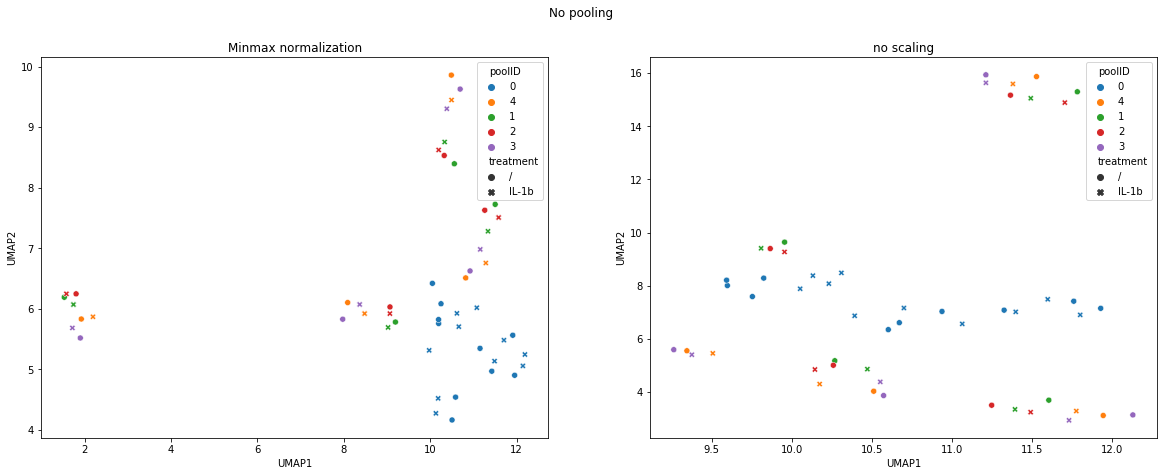

In [313]:
umapper_nonpooled_MM = umap.UMAP(n_neighbors=10)
umapper_nonpooled_MM.fit(minmax_HUVEC_NP.fillna(0))

umapper_nonpooled = umap.UMAP(n_neighbors=10)
umapper_nonpooled.fit(HUVEC_nonPooled.fillna(0))

results1= umapper_nonpooled_MM.transform(minmax_HUVEC_NP.fillna(0))
results2 = umapper_nonpooled.transform(HUVEC_nonPooled.fillna(0))

plotDataNP(results=[results1, results2])

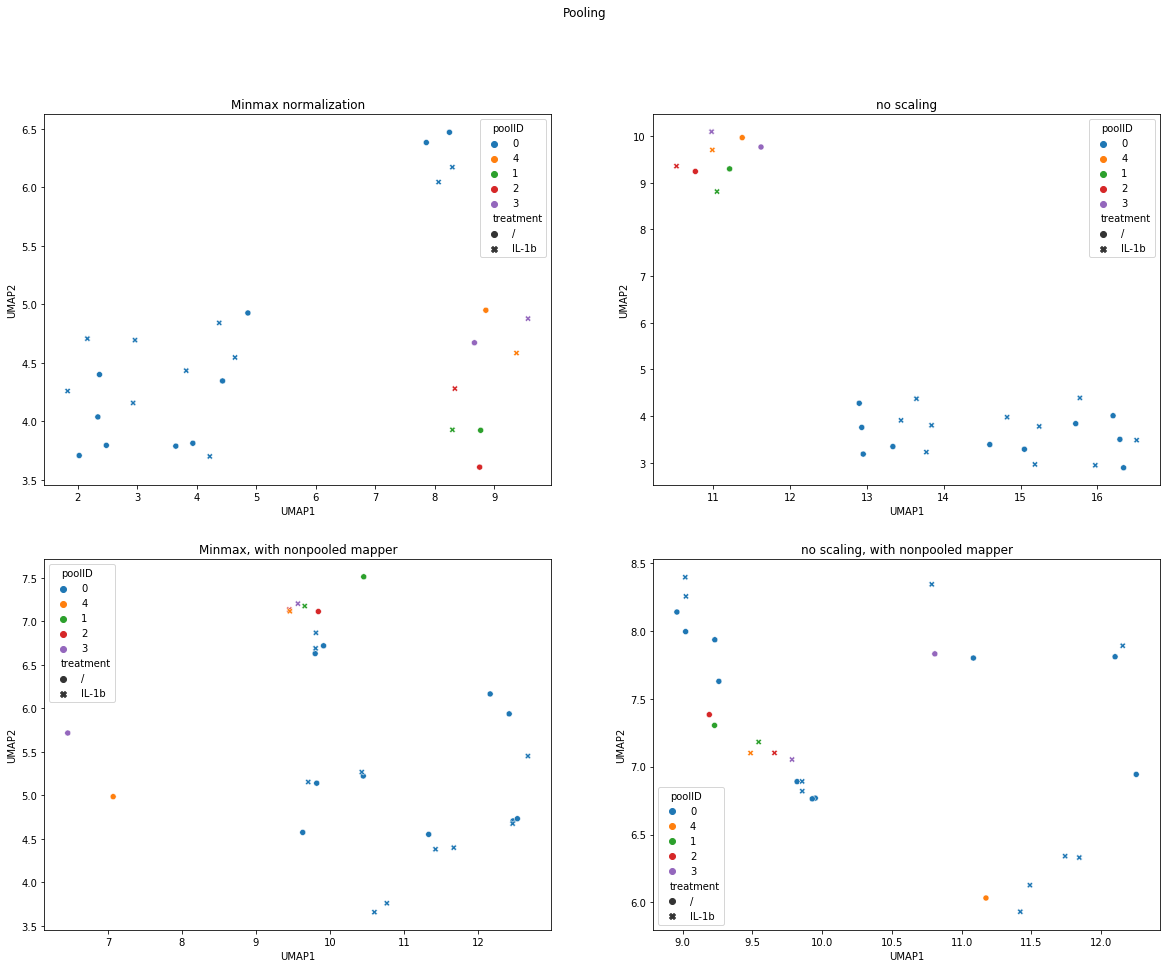

In [314]:
umapper_pooled_MM = umap.UMAP(n_neighbors=10)
umapper_pooled = umap.UMAP(n_neighbors=10)

umapper_pooled_MM.fit(minmax_HUVEC_P.fillna(0))
umapper_pooled.fit(HUVEC_pooled.fillna(0))

results1 = umapper_pooled_MM.transform(minmax_HUVEC_P.fillna(0))
results2 = umapper_pooled.transform(HUVEC_pooled.fillna(0))
results3 = umapper_nonpooled_MM.transform(minmax_HUVEC_P.fillna(0))
results4 = umapper_nonpooled.transform(HUVEC_pooled.fillna(0))

plotDataP(results=[results1, results2, results3, results4])

TSNE

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


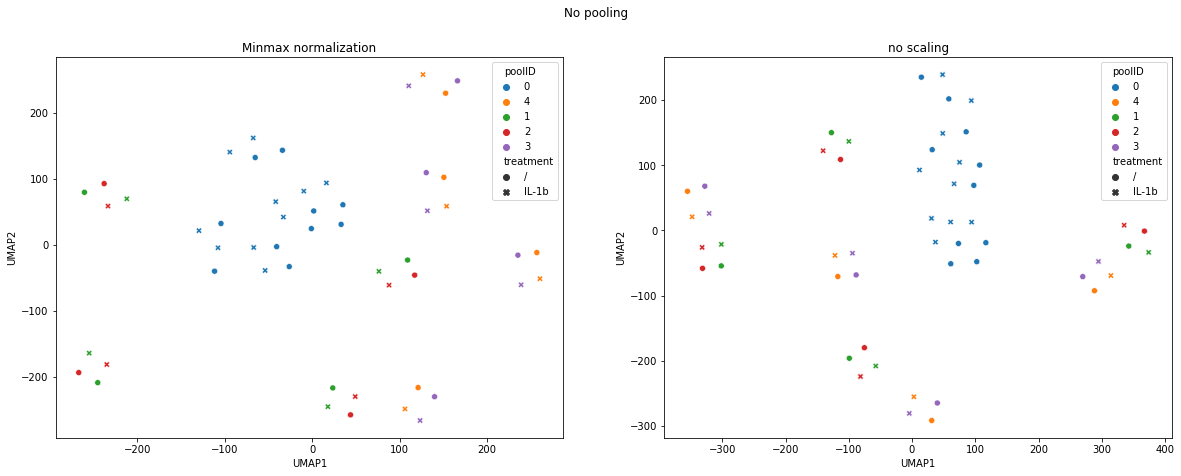

In [315]:
tsne_nonpooled_MM = TSNE(perplexity=10)
tsne_nonpooled = TSNE(perplexity=10)

results1 = tsne_nonpooled_MM.fit_transform(minmax_HUVEC_NP.fillna(0))
results2 = tsne_nonpooled.fit_transform(HUVEC_nonPooled.fillna(0))

plotDataNP(results=[results1,results2])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


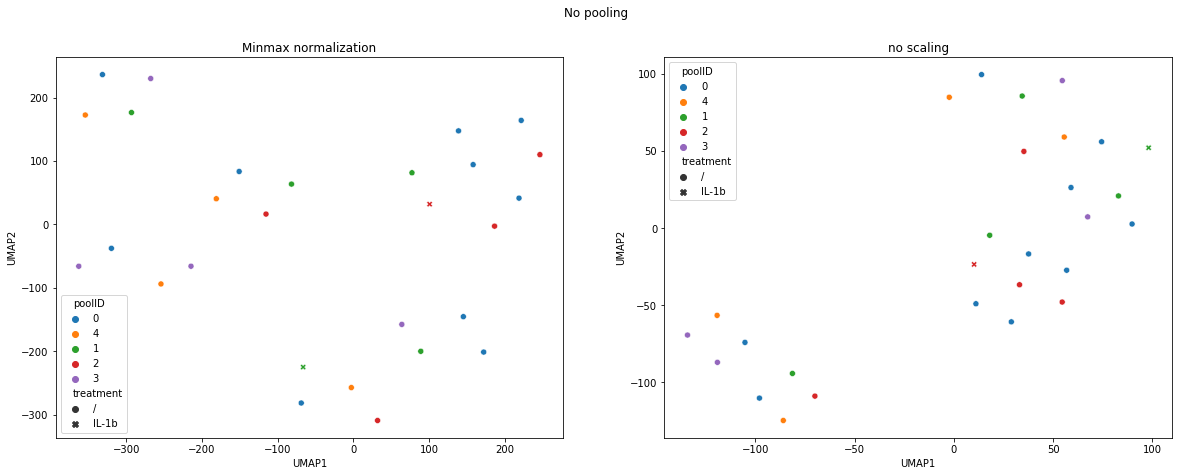

In [317]:
# POOLING
tsne_pooled_MM = TSNE(perplexity=10)
tsne_pooled = TSNE(perplexity=10)

results1 = tsne_pooled_MM.fit_transform(minmax_HUVEC_P.fillna(0))
results2 = tsne_pooled.fit_transform(HUVEC_pooled.fillna(0))

plotDataNP(results=[results1,results2])

PCA

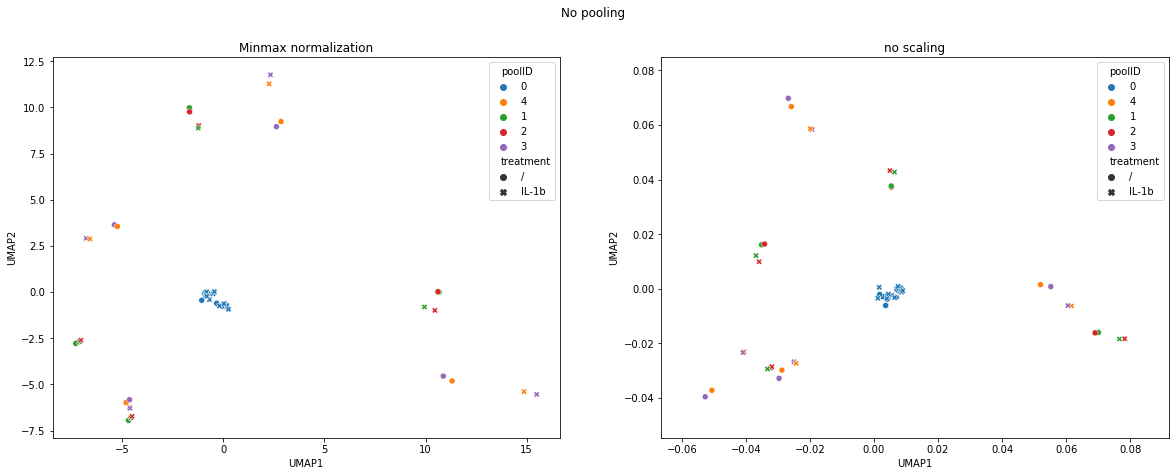

In [318]:
PCA_NP_MM = PCA(n_components=2)
PCA_NP_MM.fit(minmax_HUVEC_NP.fillna(0))

PCA_NP = PCA(n_components=2)
PCA_NP.fit(HUVEC_nonPooled.fillna(0))

results1= PCA_NP_MM.transform(minmax_HUVEC_NP.fillna(0))
results2 = PCA_NP.transform(HUVEC_nonPooled.fillna(0))

plotDataNP(results=[results1, results2])

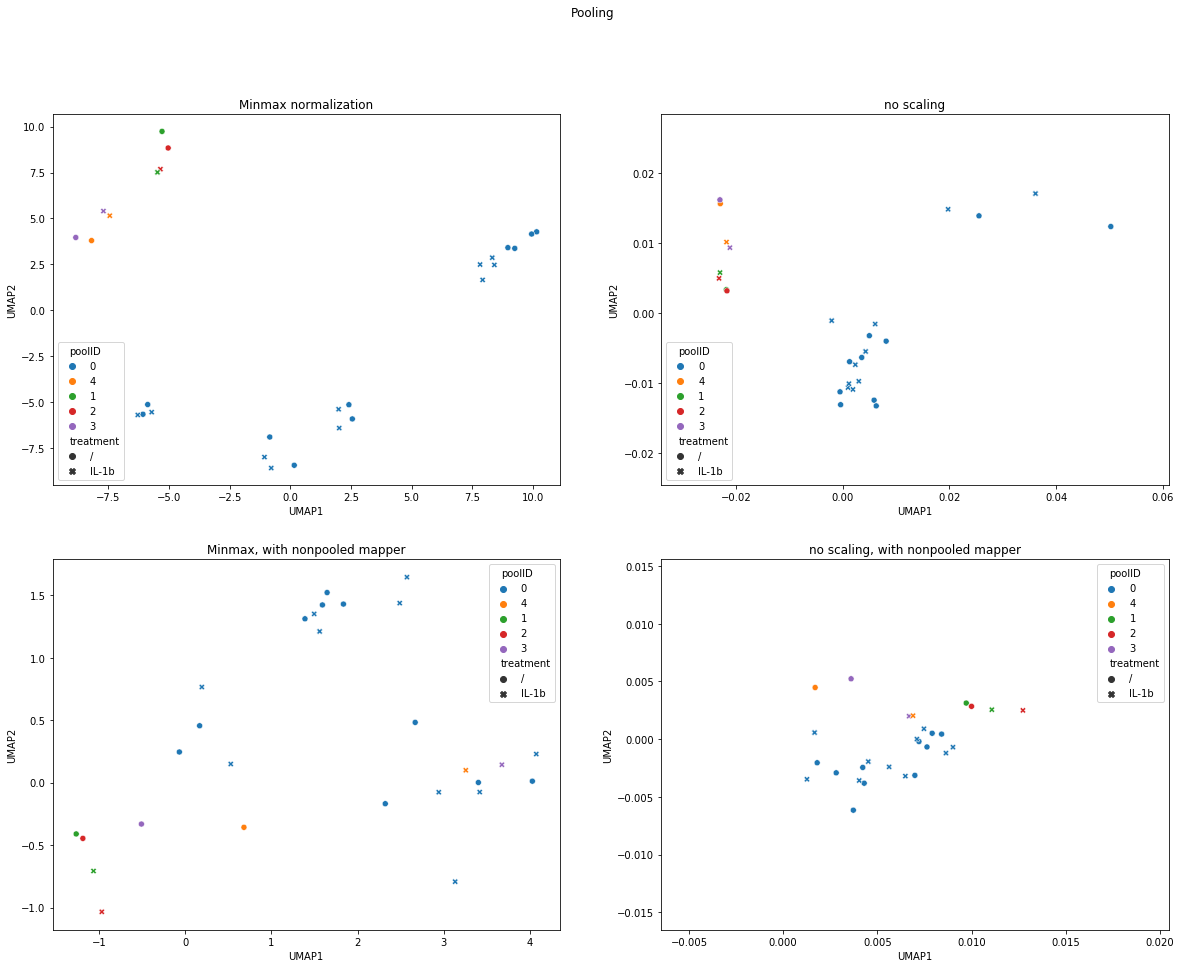

In [320]:
PCA_P_MM = PCA(n_components=2)
PCA_P = PCA(n_components=2)

PCA_P_MM.fit(minmax_HUVEC_P.fillna(0))
PCA_P.fit(HUVEC_pooled.fillna(0))

results1 = PCA_P_MM.transform(minmax_HUVEC_P.fillna(0))
results2 = PCA_P.transform(HUVEC_pooled.fillna(0))
results3 = PCA_NP_MM.transform(minmax_HUVEC_P.fillna(0))
results4 = PCA_NP.transform(HUVEC_pooled.fillna(0))

plotDataP(results=[results1, results2, results3, results4])

In [366]:
non_pooled_sample_indeces = metaNonPooled[metaNonPooled.Type == "Fraction"].index.tolist()
combined_HUVEC = pd.concat([HUVEC_nonPooled.iloc[non_pooled_sample_indeces, :], HUVEC_pooled])
combined_meta = pd.concat([metaNonPooled[metaNonPooled.Type == "Fraction"], metaPooled]).reset_index(drop = True)

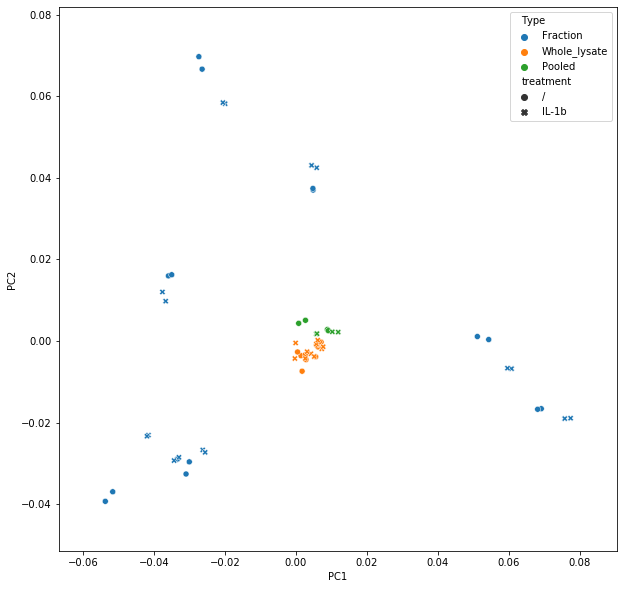

In [370]:
results = PCA(n_components=2).fit_transform(combined_HUVEC.fillna(0))
plt.figure(figsize=(10,10))
sns.scatterplot(data=pd.DataFrame(results, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = combined_meta["Type"], style=combined_meta['treatment'])

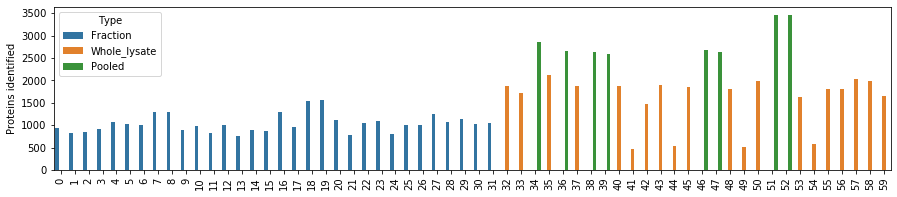

In [373]:
plt.figure(figsize=(15,3))
plt.xticks(rotation = 90)
plt.ylabel("Proteins identified")
sns.barplot(x=list(range(len(combined_HUVEC))), y=combined_HUVEC.notna().sum(axis=1).tolist(), hue = combined_meta["Type"])

---

In [2]:
meta = pd.read_csv("../Metadata/unified_metadata.csv", index_col="Unnamed: 0")

# HeLa

Compare fractions and whole-lysate samples from different projects together

In [3]:
meta["Type"] = meta.pool_id.apply(lambda x: "Whole-lysate" if x==0 else "Fraction")

In [5]:
meta.groupby(["cell_line"]).PXD_accession.nunique().sort_values()

cell_line
/           1
OVCA433     1
NCI-H460    1
MFM223      1
ME180       1
           ..
PC3         2
HepG2       2
MCF7        5
HEK293      5
HeLa        8
Name: PXD_accession, Length: 82, dtype: int64

In [8]:
meta[meta.cell_line == "HeLa"].Type.value_counts()

Fraction        352
Whole-lysate     37
Name: Type, dtype: int64

In [4]:
unpooled_nsaf = pd.read_hdf("proteome_nsaf_3.h5")
unpooled_nsaf = unpooled_nsaf.pivot(index="assay_id",columns="uniprot_id",values="NSAF")

pooled_nsaf = pd.read_hdf("proteome_nsaf_pooled_3.h5")
pooled_nsaf = pooled_nsaf.pivot(index="assay_id",columns="uniprot_id",values="NSAF")

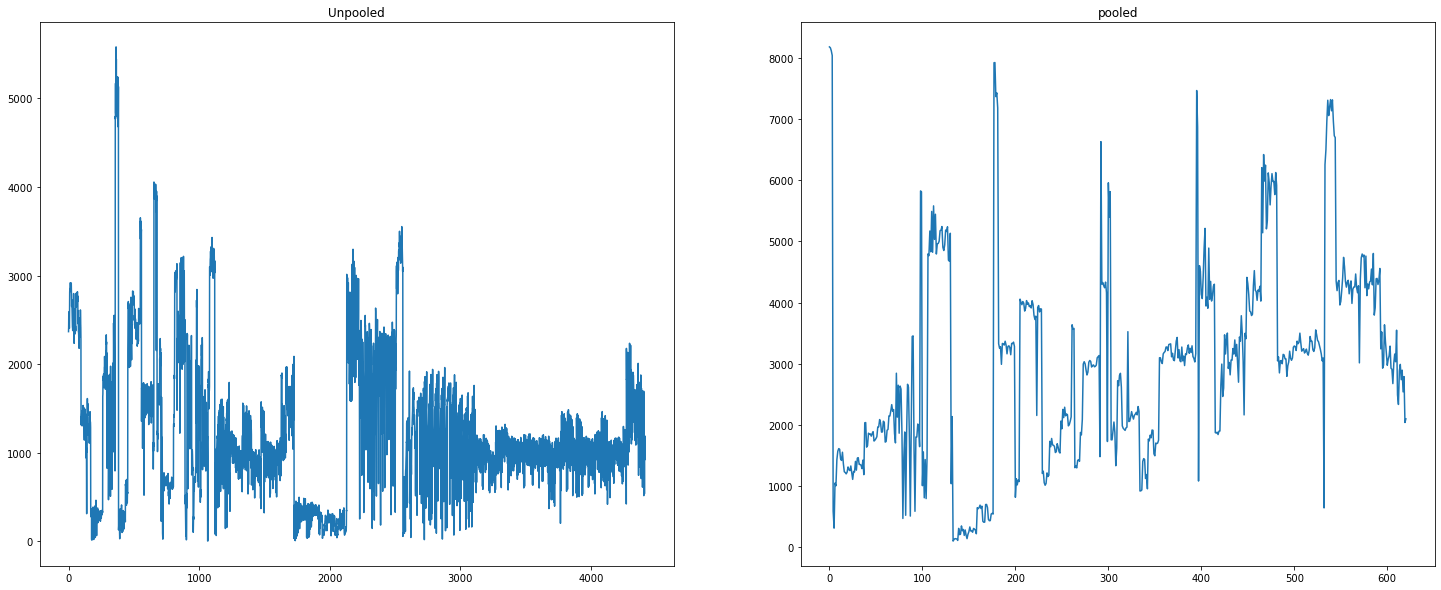

In [10]:
fig, ax = plt.subplots(1,2, figsize=(25,10))
ax[0].set_title("Unpooled")
ax[1].set_title("pooled")

sns.lineplot(y=unpooled_nsaf.notna().sum(axis=1),x=range(len(unpooled_nsaf)), ax=ax[0])
sns.lineplot(y=pooled_nsaf.notna().sum(axis=1),x=range(len(pooled_nsaf)), ax=ax[1])

In [7]:
def overview_data_pca(meta, nsaf, nsaf_pooled):
    
    fig, ax = plt.subplots(1,2, figsize=(25,10))
    ax[0].set_title("pooled")
    ax[1].set_title("unpooled")

    results = PCA(n_components=2).fit_transform(nsaf_pooled.fillna(0))
    results2 = PCA(n_components=2).fit_transform(nsaf.fillna(0))


    sns.scatterplot(data=pd.DataFrame(results, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", 
                    hue = pd.merge(nsaf_pooled, meta, on = "assay_id")["PXD_accession"], 
                    style=pd.merge(nsaf_pooled, meta, on = "assay_id")["Type"], ax=ax[0])

    sns.scatterplot(data=pd.DataFrame(results2, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", 
                    hue = pd.merge(nsaf, meta, on = "assay_id")["PXD_accession"], 
                    style=pd.merge(nsaf, meta, on = "assay_id")["Type"], ax=ax[1])

In [11]:
hela_unpooled = unpooled_nsaf[unpooled_nsaf.index.isin(meta[meta.cell_line=="HeLa"].assay_id)]
hela_pooled = pooled_nsaf[pooled_nsaf.index.isin(meta[meta.cell_line=="HeLa"].assay_id)]

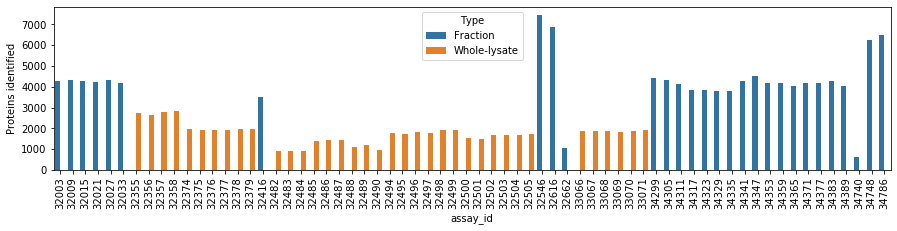

In [12]:
plt.figure(figsize=(15,3))
plt.xticks(rotation = 90)
plt.ylabel("Proteins identified")
sns.barplot(x=hela_pooled.reset_index().assay_id, y=hela_pooled.notna().sum(axis=1).tolist(), hue = pd.merge(hela_pooled, meta, on = "assay_id")["Type"])

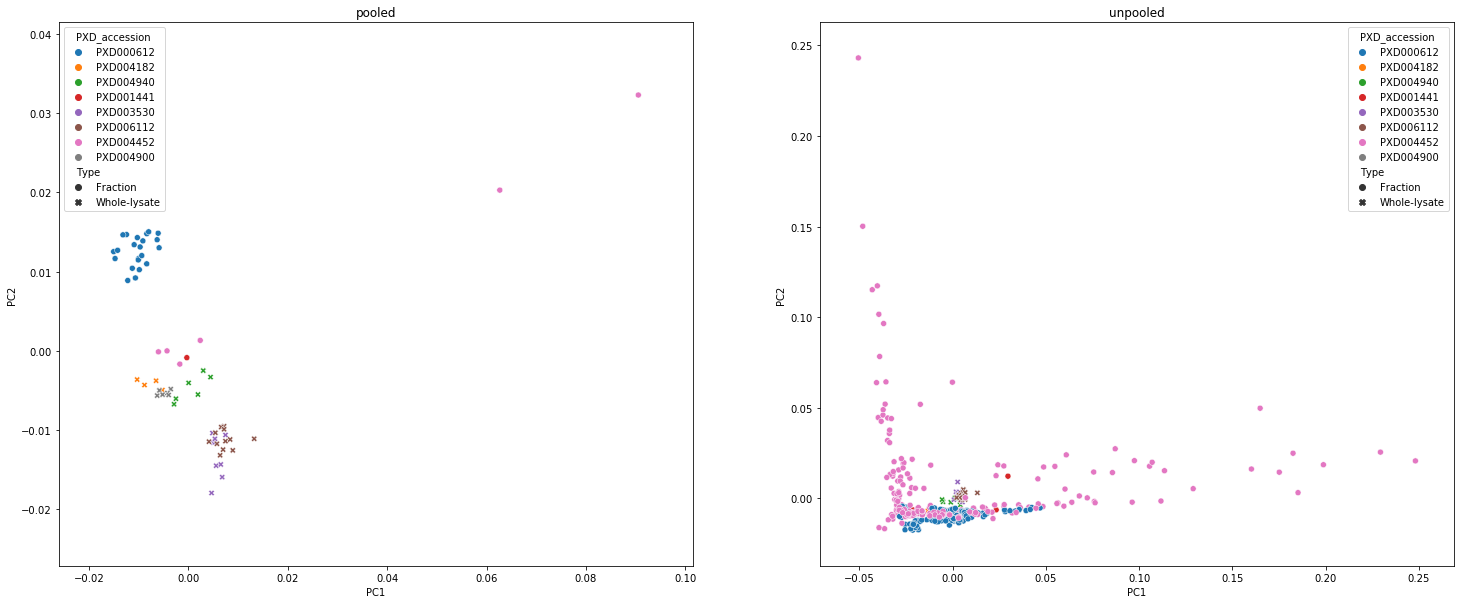

In [20]:
overview_data_pca(meta, hela_unpooled, hela_pooled)

Drop 32546 and 32616 as these are outliers

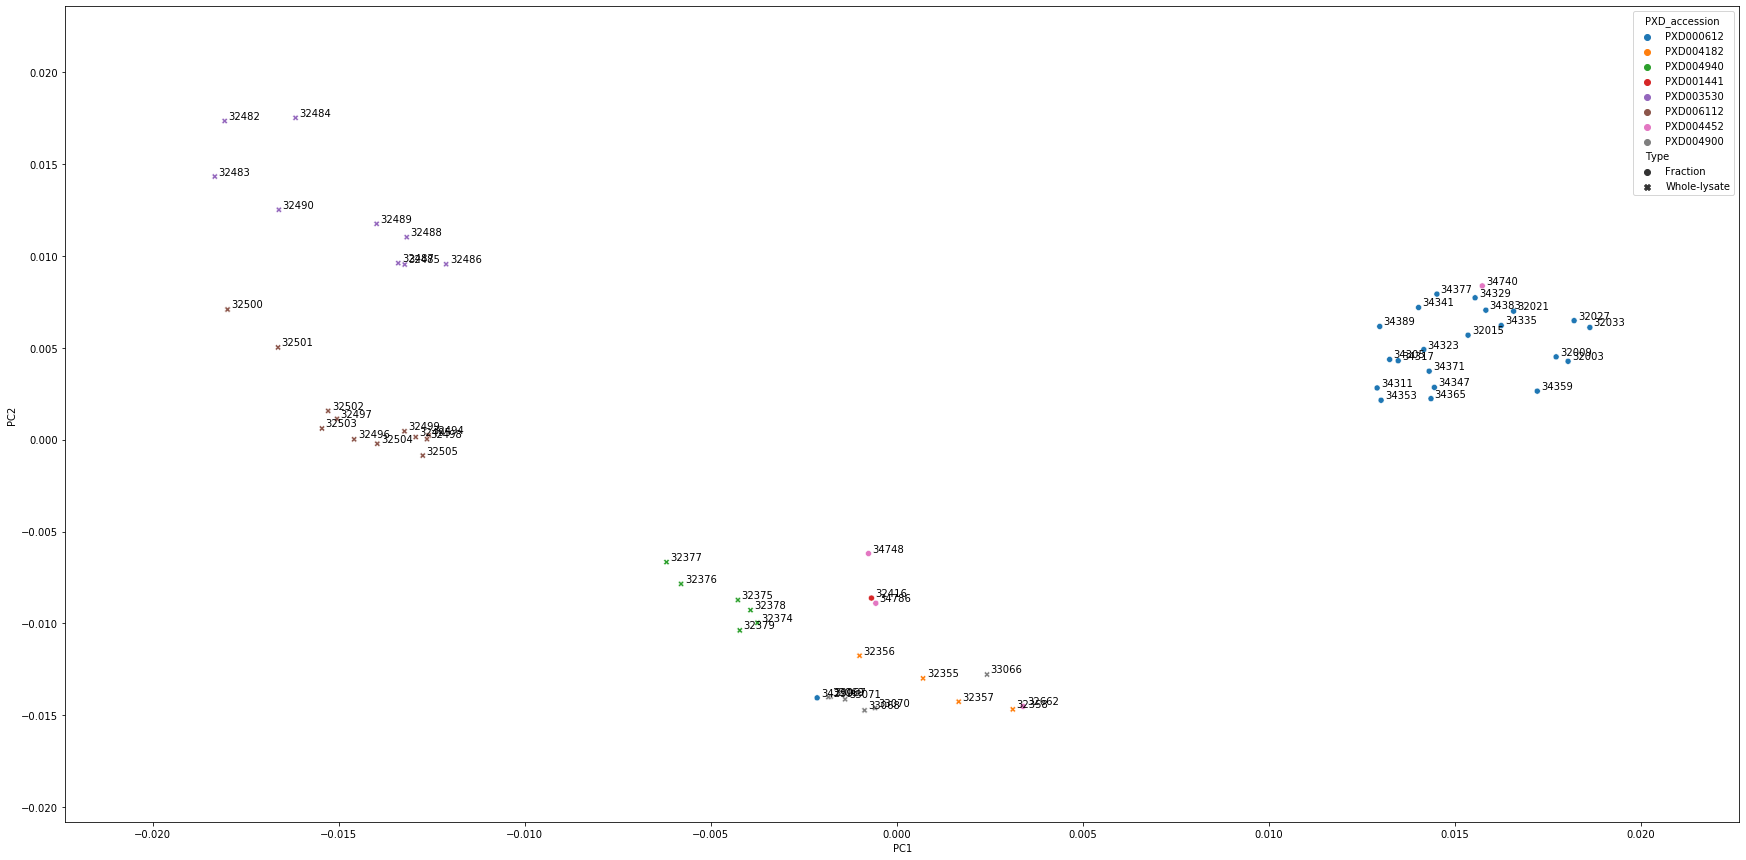

In [14]:
plt.figure(figsize=(30,15))
results = PCA(n_components=2).fit_transform(hela_pooled.loc[~hela_pooled.index.isin([34740, 32662])].fillna(0))

sns.scatterplot(data=pd.DataFrame(results, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", 
                hue = pd.merge(hela_pooled.loc[~hela_pooled.index.isin([32546,32616])], meta, on = "assay_id")["PXD_accession"], 
                style=pd.merge(hela_pooled.loc[~hela_pooled.index.isin([32546,32616])], meta, on = "assay_id")["Type"])

for i in range(0, results.shape[0]):
    plt.text(results[i][0] + .0001, results[i][1] +.0001, 
            pd.merge(hela_pooled.loc[~hela_pooled.index.isin([32546,32616])], meta, on = "assay_id").iloc[i,:].assay_id)

# MCF7

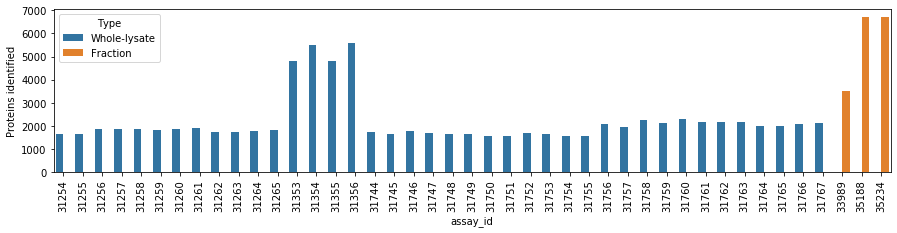

In [21]:
MCF7_unpooled = unpooled_nsaf[unpooled_nsaf.index.isin(meta[meta.cell_line=="MCF7"].assay_id)]
MCF7_pooled = pooled_nsaf[pooled_nsaf.index.isin(meta[meta.cell_line=="MCF7"].assay_id)]

plt.figure(figsize=(15,3))
plt.xticks(rotation = 90)
plt.ylabel("Proteins identified")
sns.barplot(x=MCF7_pooled.reset_index().assay_id, y=MCF7_pooled.notna().sum(axis=1).tolist(), hue = pd.merge(MCF7_pooled, meta, on = "assay_id")["Type"])

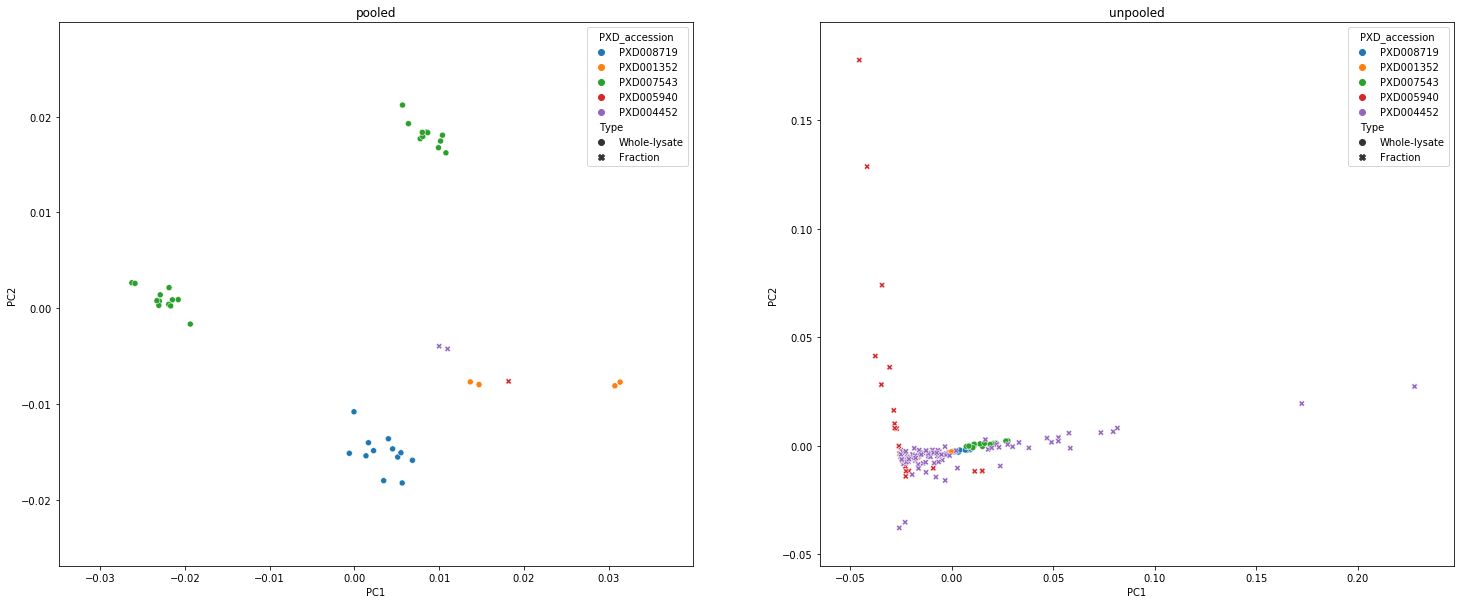

In [22]:
overview_data_pca(meta, MCF7_unpooled, MCF7_pooled)

In [24]:
meta[meta.PXD_accession == "PXD007543"].sub_cell.unique()

array(['/', 'MCF7-CDH1 KO'], dtype=object)

# Check MCF7 vs HeLa

In [27]:
MCF7_hela_unpooled = unpooled_nsaf[unpooled_nsaf.index.isin(meta[meta.cell_line.isin(["MCF7", "HeLa"])].assay_id)]
MCF7_hela_pooled = pooled_nsaf[pooled_nsaf.index.isin(meta[meta.cell_line.isin(["MCF7", "HeLa"])].assay_id)]

In [29]:
MCF7_hela_pooled=MCF7_hela_pooled.loc[~MCF7_hela_pooled.index.isin([34740, 32662])]
MCF7_hela_unpooled=MCF7_hela_unpooled.loc[~MCF7_hela_unpooled.index.isin([34740, 32662])]

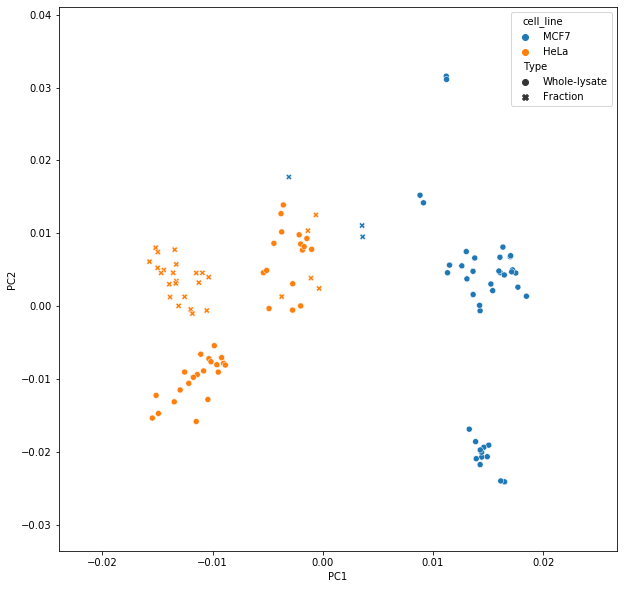

In [32]:
results = PCA(n_components=2).fit_transform(MCF7_hela_pooled.fillna(0))

plt.figure(figsize=(10,10))
sns.scatterplot(data=pd.DataFrame(results, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", 
                hue = pd.merge(MCF7_hela_pooled, meta, on = "assay_id")["cell_line"], 
                style=pd.merge(MCF7_hela_pooled, meta, on = "assay_id")["Type"])

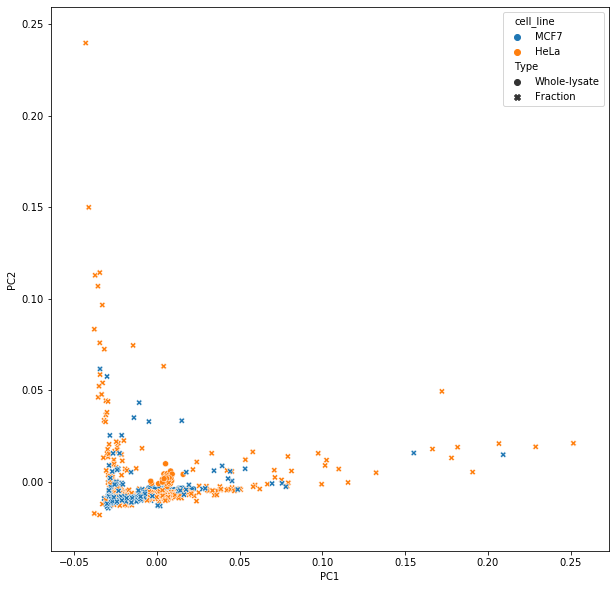

In [33]:
results = PCA(n_components=2).fit_transform(MCF7_hela_unpooled.fillna(0))

plt.figure(figsize=(10,10))
sns.scatterplot(data=pd.DataFrame(results, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", 
                hue = pd.merge(MCF7_hela_unpooled, meta, on = "assay_id")["cell_line"], 
                style=pd.merge(MCF7_hela_unpooled, meta, on = "assay_id")["Type"])

# Breast cell line clustering

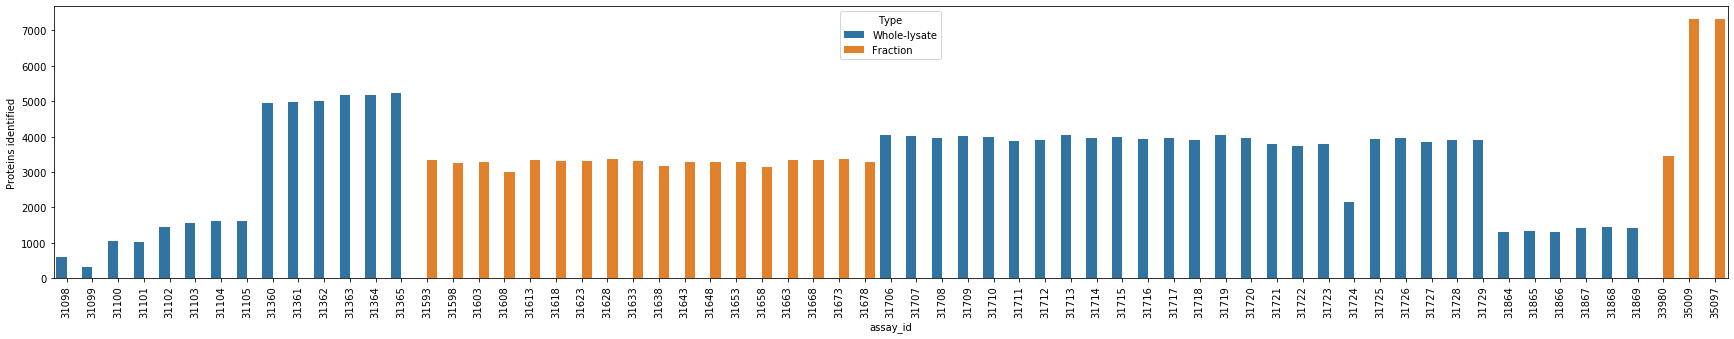

In [17]:
breast_unpooled = unpooled_nsaf[unpooled_nsaf.index.isin(meta[meta.tissue_type=="brain"].assay_id)]
breast_pooled = pooled_nsaf[pooled_nsaf.index.isin(meta[meta.tissue_type=="brain"].assay_id)]

plt.figure(figsize=(30,5))
plt.xticks(rotation = 90)
plt.ylabel("Proteins identified")
sns.barplot(x=breast_pooled.reset_index().assay_id, y=breast_pooled.notna().sum(axis=1).tolist(), hue = pd.merge(breast_pooled, meta, on = "assay_id")["Type"])

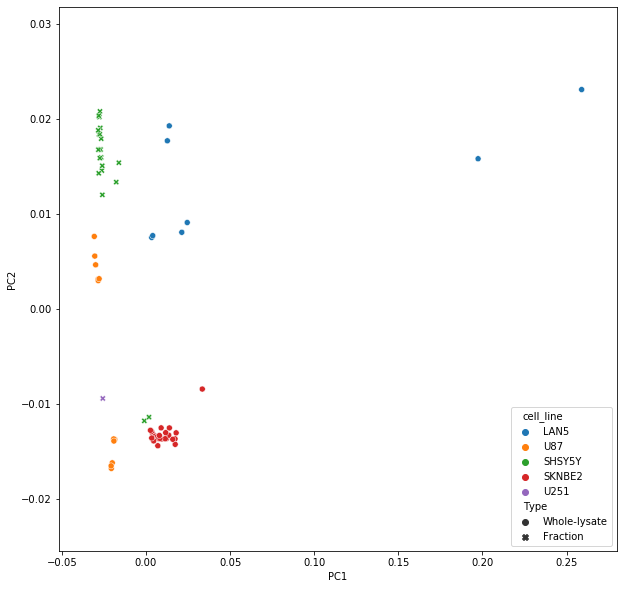

In [15]:
breast_unpooled = unpooled_nsaf[unpooled_nsaf.index.isin(meta[meta.tissue_type=="brain"].assay_id)]
breast_pooled = pooled_nsaf[pooled_nsaf.index.isin(meta[meta.tissue_type=="brain"].assay_id)]
breast_pooled=breast_pooled.loc[~breast_pooled.index.isin([34740, 32662])]
breast_unpooled=breast_unpooled.loc[~breast_unpooled.index.isin([34740, 32662])]

results = PCA(n_components=2).fit_transform(breast_pooled.fillna(0))

plt.figure(figsize=(10,10))
sns.scatterplot(data=pd.DataFrame(results, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", 
                hue = pd.merge(breast_pooled, meta, on = "assay_id")["cell_line"], 
                style=pd.merge(breast_pooled, meta, on = "assay_id")["Type"])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


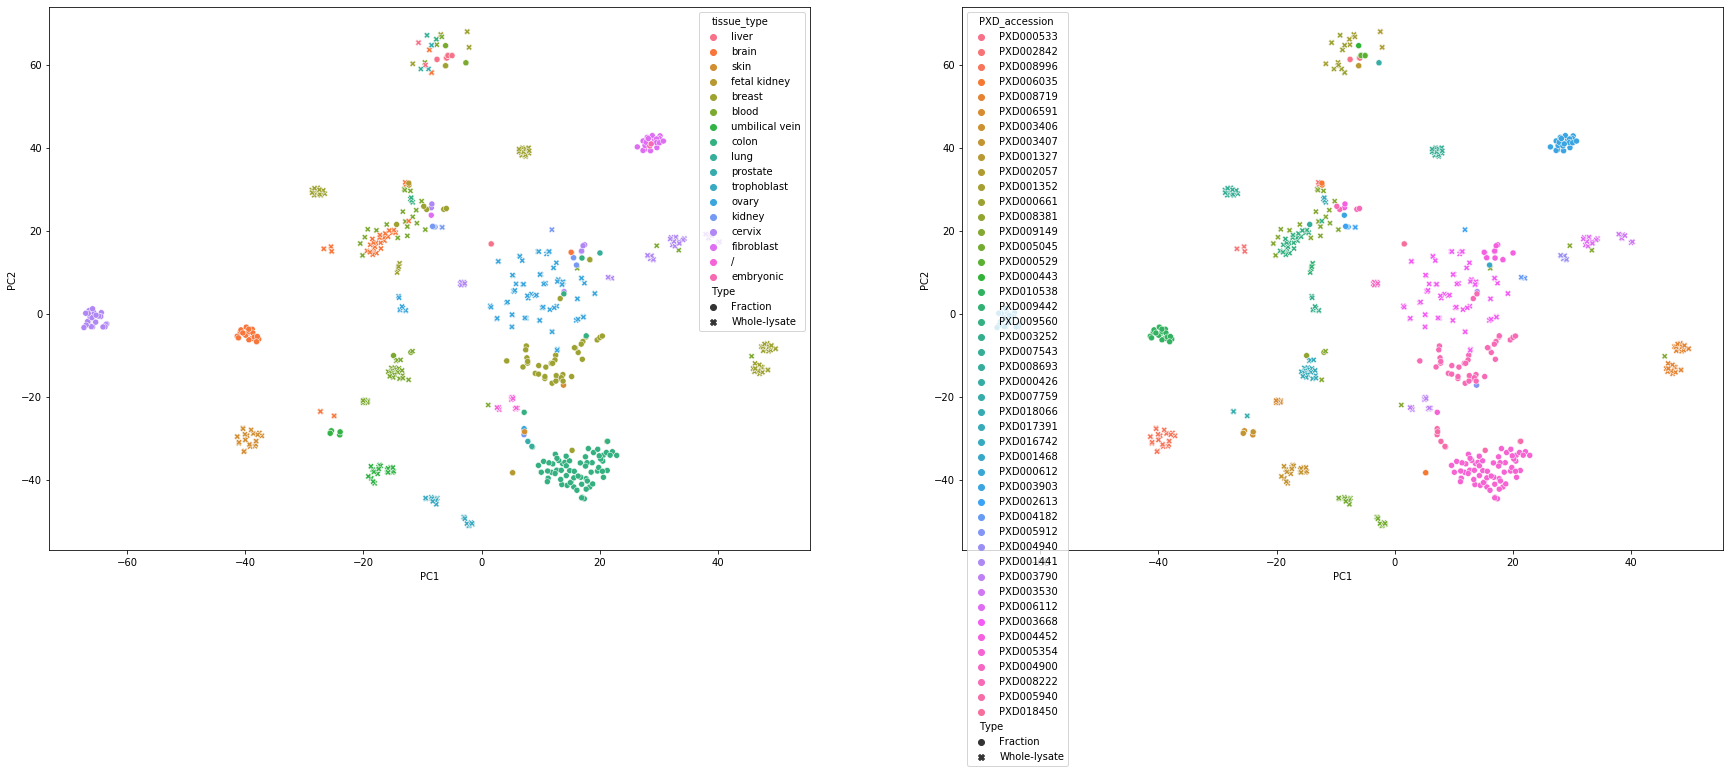

In [8]:
results = TSNE(perplexity=15).fit_transform(pooled_nsaf.fillna(0))

fig, ax = plt.subplots(1,2, figsize=(30,10))
sns.scatterplot(data=pd.DataFrame(results, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", 
                hue = pd.merge(pooled_nsaf, meta, on = "assay_id")["tissue_type"], 
                style=pd.merge(pooled_nsaf, meta, on = "assay_id")["Type"], ax = ax[0])

sns.scatterplot(data=pd.DataFrame(results, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", 
                hue = pd.merge(pooled_nsaf, meta, on = "assay_id")["PXD_accession"], 
                style=pd.merge(pooled_nsaf, meta, on = "assay_id")["Type"], ax = ax[1])